In [15]:
%%time
import os
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

import pandas as pd
import ast
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.utils import resample

from keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
import random

from lime import lime_text
from lime.lime_text import LimeTextExplainer
import contractions
import re

from langdetect import detect


CPU times: total: 15.6 ms
Wall time: 87.6 ms


### **Utils**

In [16]:
def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return None

### **Data Import**

In [9]:
file_path = os.path.join(parent_dir, 'data', 'raw', 'CU-NLP.csv')
cu_nlp = pd.read_csv(file_path, sep=';', encoding='latin1')
cu_nlp

,no,question1,question2,grade
0,0,"If the question is IR-Based, I will do the fol...",Using semantic analysis methods. We can use ve...,25
1,1,"If the question is IR-Based, I will do the fol...","we should use vector space model. firstly, bin...",25
2,2,"If the question is IR-Based, I will do the fol...","Assume we have a question like "" Why the sky i...",50
3,3,"If the question is IR-Based, I will do the fol...",We can use Vector Space Model that is represen...,25
4,4,"If the question is IR-Based, I will do the fol...",In this corpus we will use sentence segmenting...,50
...,...,...,...,...
166,166,The problem like that can solve by word sense ...,Most important prob. are related to ambiguite...,0
167,167,The problem like that can solve by word sense ...,Lexical WordNet ile zerim. Semantic Syntatic,40
168,168,The problem like that can solve by word sense ...,These can be solved by using the rule based ma...,40
169,169,The problem like that can solve by word sense ...,before translating a word that has many meanin...,100


### **Data Exploration**

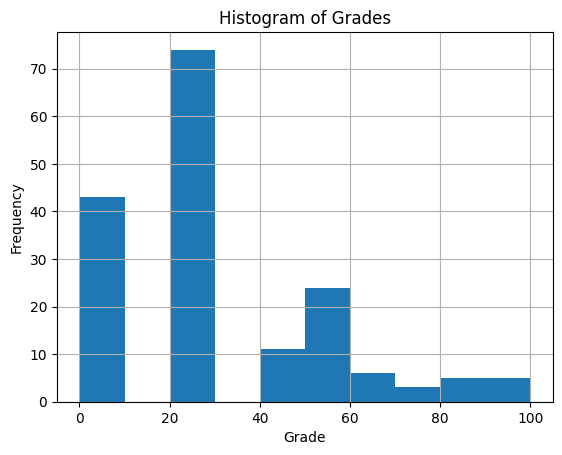

In [10]:
cu_nlp['grade'].hist()

plt.title('Histogram of Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')

plt.show()

In [11]:
cu_nlp['question1'].value_counts()

question1
The problem like that can solve by word sense disambiguation. \nTo do that: \nFirstly, I will build or select raw lexical materials such as WordNet, BabelNet, etc. The sentence?s each word has a sense and each sense of the word is a node in WordNet. \nSo, I will look up the nodes to relation. If some of the senses are not close enough to the others on the nodes, then I can say that this is not in a meaningful relationship with the others.                                                                                                                                                                                                                                                                                                                                                                                                                                                                         86
If the question is IR-Based, I will do the following: \nI can assume the question as a q

In [12]:
cu_nlp['question2'].value_counts()

question2
Using semantic analysis methods. We can use vector space model.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   1
There exists a semantic ambiguity due to the same word having more than one meanings. To solve this ambiguity, "bag of nearby words" way can be used which checks for dictionary definitions and appoints the most appropriate translation is given. For the given example, software will check for "fisherman" in dictionary and find "sea" related results therefore "bank" will have th

In [17]:
cu_nlp['lang'] = cu_nlp['question2'].apply(detect_language)
cu_nlp

,no,question1,question2,grade,lang
0,0,"If the question is IR-Based, I will do the fol...",Using semantic analysis methods. We can use ve...,25,en
1,1,"If the question is IR-Based, I will do the fol...","we should use vector space model. firstly, bin...",25,en
2,2,"If the question is IR-Based, I will do the fol...","Assume we have a question like "" Why the sky i...",50,en
3,3,"If the question is IR-Based, I will do the fol...",We can use Vector Space Model that is represen...,25,en
4,4,"If the question is IR-Based, I will do the fol...",In this corpus we will use sentence segmenting...,50,en
...,...,...,...,...,...
166,166,The problem like that can solve by word sense ...,Most important prob. are related to ambiguite...,0,en
167,167,The problem like that can solve by word sense ...,Lexical WordNet ile zerim. Semantic Syntatic,40,en
168,168,The problem like that can solve by word sense ...,These can be solved by using the rule based ma...,40,en
169,169,The problem like that can solve by word sense ...,before translating a word that has many meanin...,100,en


In [18]:
cu_nlp["lang"].value_counts()

lang
en    141
tr     27
pl      1
it      1
de      1
Name: count, dtype: int64

### **Data Preprocessing**